In [2]:
import sys
sys.path.append('../src')

from exlib.datasets.massmaps import MassMapsConvnetForImageRegression, MassMapsConvnetConfig

In [3]:
config = MassMapsConvnetConfig()
model = MassMapsConvnetForImageRegression(config)

In [4]:
import torch
import os

data_dir = '/shared_data0/weiqiuy/datasets/cosmogrid'
weights_path = os.path.join(data_dir, 'CNN_mass_maps.pth')
state_dict = torch.load(weights_path)

In [5]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
model.save_pretrained(f'../../MassMapsConvnet')

In [11]:
model2 = MassMapsConvnetForImageRegression.from_pretrained(f'../../MassMapsConvnet')

In [10]:
model3 = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')

# Data

In [2]:
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import numpy as np
import os
from tqdm.auto import tqdm

class MassMaps(TensorDataset): 
    def __init__(self, data_dir, split='train', download=False,
                 verbose=0):
        assert split in ['train', 'val', 'test']
        if download: 
            raise ValueError("download not implemented")
            
        self.data_dir = data_dir
            
        if split in ['train', 'val']: 
            X,y = [os.path.join(data_dir, f"{a}_maps_Cosmogrid_100k.npy")
                                for a in ["X", "y"]]
        elif split == 'test': 
            X,y = [os.path.join(data_dir, f"test_{a}.npy")
                                for a in ["x", "y"]]
        else: 
            raise ValueError("Split should be either train or test")
        
        X,y = [torch.from_numpy(np.load(a)) for a in (X,y)]
        X = X.unsqueeze(1).float()
        
        if split in ['train', 'val']: 
            # number of samples
            num_samples = len(y)
            # split the sample for training ----------
            train_split = int(0.90*num_samples)
            np.random.seed(42)
            train_x, val_x = np.split(X, [train_split])
            train_y, val_y = np.split(y, [train_split])
            if split == 'train':
                X, y = train_x, train_y
            else: # split == 'val'
                X, y = val_x, val_y
            params_mask = np.array([True,False,False,True,False,False])
            y = y[:, params_mask]
        
        if verbose >= 1:
            print(f'# samples used for {split}:', len(y))
        
        super(MassMaps,self).__init__(X,y)

In [11]:
data_dir = '/shared_data0/weiqiuy/datasets/cosmogrid'
train_dataset = MassMaps(data_dir, split='train', verbose=1)
val_dataset = MassMaps(data_dir, split='val', verbose=1)
test_dataset = MassMaps(data_dir, split='test', verbose=1)

# samples used for train: 90000
# samples used for val: 10000
# samples used for test: 10000


In [8]:
len(train_dataset.tensors)

2

In [9]:
train_dataset.tensors[0].shape

torch.Size([90000, 1, 66, 66])

In [10]:
train_dataset.tensors[1].shape

torch.Size([90000, 2])

In [12]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

d = {
    'train': Dataset.from_dict({'input': train_dataset.tensors[0], 'label': train_dataset.tensors[1]}),
    'validation': Dataset.from_dict({'input': val_dataset.tensors[0], 'label': val_dataset.tensors[1]}),
    'test': Dataset.from_dict({'input': test_dataset.tensors[0], 'label': test_dataset.tensors[1]}),
}

In [13]:
dataset = DatasetDict(d)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'label'],
        num_rows: 90000
    })
    validation: Dataset({
        features: ['input', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input', 'label'],
        num_rows: 10000
    })
})

In [15]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
dataset.push_to_hub("BrachioLab/massmaps-cosmogrid-100k")

Pushing dataset shards to the dataset hub:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/23 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

In [17]:
from datasets import load_dataset

dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/90000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'label'],
        num_rows: 90000
    })
    validation: Dataset({
        features: ['input', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input', 'label'],
        num_rows: 10000
    })
})

# Metric

In [42]:
from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool
import torch

class MassMapsWatershed(nn.Module):
    def apply_watershed(self, image, compactness=0):
        image = (image * 255).astype(np.uint8)
        distance = ndimage.distance_transform_edt(image)
        coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(mask)
        raw_labels = watershed(-distance, markers, mask=image,
                               compactness=compactness)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_watershed(image[0].numpy()))
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        daf_preds = torch.nn.utils.rnn.pad_sequence(daf_preds, batch_first=True)
        return daf_preds

In [43]:
train_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='train')

In [44]:
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
import torch
X,y = [torch.tensor(a) for a in (X,y)]
X.shape, y.shape

(torch.Size([2, 1, 66, 66]), torch.Size([2, 2]))

In [46]:
watershed_dafer = MassMapsWatershed()
watershed_dafs = watershed_dafer(X)
watershed_dafs.shape, len(watershed_dafs), watershed_dafs[0].shape, watershed_dafs[1].shape

(torch.Size([2, 75, 66, 66]),
 2,
 torch.Size([75, 66, 66]),
 torch.Size([75, 66, 66]))

In [89]:
# metric test
daf_preds = watershed_dafs
masked_imgs = daf_preds * X # (N, M, H, W)
sigma = X.flatten(2).std(dim=-1)
mask_intensities = (masked_imgs * (daf_preds > 1e-4)).flatten(2).sum(-1) /  (daf_preds > 1e-4).flatten(2).sum(-1)
num_masks = (daf_preds > 1e-4).flatten(2).sum(-1).bool().sum(-1)
voids = (mask_intensities < 0 * sigma)
num_voids = voids.sum(-1)
clusters = (mask_intensities > 3 * sigma)
num_clusters = clusters.sum(-1)
perc_semantic = (num_voids + num_clusters) / num_masks
semantic = voids.logical_or(clusters)
semantic_coverage = (daf_preds * semantic[:,:,None,None]).sum(1).flatten(1).bool().sum(-1) / X.flatten(1).shape[-1]
sem_cov_weighted_perc_sem_groups = perc_semantic * semantic_coverage

In [66]:
# metric test
daf_preds = watershed_dafs
masked_imgs = daf_preds * X # (N, M, H, W)
sigma = X.flatten(2).std(dim=-1)

sigma.shape, X.flatten(1).shape

(torch.Size([2, 1]), torch.Size([2, 4356]))

In [58]:
X.shape, X.flatten(2).shape

(torch.Size([2, 1, 66, 66]), torch.Size([2, 1, 4356]))

In [65]:
mask_intensities = (masked_imgs * (daf_preds > 1e-4)).flatten(2).sum(-1) /  (daf_preds > 1e-4).flatten(2).sum(-1)
mask_intensities.shape

torch.Size([2, 75])

In [71]:
num_masks = (daf_preds > 1e-4).flatten(2).sum(-1).bool().sum(-1)
num_masks

tensor([44, 75])

In [80]:
voids = (mask_intensities < 0 * sigma)

In [81]:
num_voids = voids.sum(-1)
num_voids

tensor([20, 27])

In [82]:
clusters = (mask_intensities > 3 * sigma)
num_clusters = clusters.sum(-1)
num_clusters

tensor([10,  2])

In [78]:
perc_semantic = (num_voids + num_clusters) / num_masks
perc_semantic

tensor([0.6818, 0.3867])

In [85]:
semantic = voids.logical_or(clusters)
semantic, semantic.shape

(tensor([[ True, False,  True, False,  True,  True,  True, False, False,  True,
           True,  True, False, False, False,  True,  True,  True,  True,  True,
           True,  True,  True, False,  True,  True, False,  True,  True,  True,
           True,  True,  True, False,  True,  True, False, False,  True, False,
           True, False,  True,  True, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False],
         [ True, False,  True, False, False,  True,  True, False, False, False,
          False, False, False,  True, False, False,  True, False, False,  True,
           True, False,  True,  True,  True,  True, False,  True,  True, False,
           True,  True, False, False, False, False, False, False, False, False,
          False, False,  True, False, False, False, False, False,  True, F

In [87]:
semantic_coverage = (daf_preds * semantic[:,:,None,None]).sum(1).flatten(1).bool().sum(-1) / X.flatten(1).shape[-1]
semantic_coverage

tensor([0.9894, 0.7220])

In [88]:
sem_cov_weighted_perc_sem_groups = perc_semantic * semantic_coverage
sem_cov_weighted_perc_sem_groups

tensor([0.6746, 0.2792])

In [67]:
mask_intensities > 3 * sigma

tensor([[False, False, False, False, False,  True, False, False, False, False,
          True, False, False, False, False,  True,  True, False,  True,  True,
          True,  True,  True, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
       

In [68]:
mask_intensities < 0 * sigma

tensor([[ True, False,  True, False,  True, False,  True, False, False,  True,
         False,  True, False, False, False, False, False,  True, False, False,
         False, False, False, False,  True,  True, False,  True,  True,  True,
          True,  True, False, False,  True,  True, False, False,  True, False,
          True, False,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [ True, False,  True, False, False,  True, False, False, False, False,
         False, False, False,  True, False, False,  True, False, False,  True,
          True, False,  True, False,  True,  True, False,  True,  True, False,
          True,  True, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False,  True, False,
       

In [70]:
(daf_preds > 1e-4).flatten(2).sum(-1).bool().sum(-1)

tensor([44, 75])

In [60]:
(masked_imgs * (daf_preds > 1e-4)).flatten(2).sum(-1).shape

torch.Size([2, 75])

In [61]:
(daf_preds > 1e-4).flatten(2).sum(-1)

tensor([[3877,    5,   83,    1,   20,    2,  105,    7,    3,   19,    1,    9,
            1,    6,    4,    1,    4,    4,    2,    1,    1,    1,    2,    2,
           10,    5,    1,   11,   13,   14,   27,    9,    3,    3,   10,   43,
            1,    1,    7,    1,    6,   10,   17,    3,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [1857,  100,   84,   59,   42,   11,    6,    1,  128,   76,   10,    3,
           25,   39,    7,    5,    7,    8,   36,   29,   32,    8,   49,    1,
           17,   17,   17,  134,   10,    2,    4,   26,   15,   13,   12,    8,
           29,    7,   61,   14,    7,    4,  209,   25,   16,   31,   15,   13,
           23,   18,   63,    6,   35,   19,   18,   38,   13,   71,    3,   20,
           15,  102,   34,  242,   12,    3,   77,    3,   12,   86,   13,    5,


In [56]:
(masked_imgs * (daf_preds > 1e-4)).flatten(1).mean(-1)

tensor([-2.2622e-05,  3.3137e-06])

In [96]:
class MassMapsMetrics(nn.Module):
    def __init__(self, void_threshold=0, cluster_threshold=3):
        super().__init__()
        self.void_threshold = void_threshold
        self.cluster_threshold = cluster_threshold
        self.daf_types = ['other', 'void', 'cluster']
        self.daf_types2id = {
            'other': 0,
            'void': 1,
            'cluster': 2
        }
        
    def forward(self, zp, x):
        """
        zp: (N, M, H, W)
        x: image (N, 1, H, W)
        """
        # metric test
        masked_imgs = zp * x # (N, M, H, W)
        sigma = x.flatten(2).std(dim=-1)
        mask_intensities = (masked_imgs * (zp > 1e-4)).flatten(2).sum(-1) /  (zp > 1e-4).flatten(2).sum(-1)
        num_masks = (zp > 1e-4).flatten(2).sum(-1).bool().sum(-1)
        voids = (mask_intensities < self.void_threshold * sigma)
        num_voids = voids.sum(-1)
        clusters = (mask_intensities > self.cluster_threshold * sigma)
        num_clusters = clusters.sum(-1)
        perc_semantic = (num_voids + num_clusters) / num_masks
        semantic = voids.logical_or(clusters)
        semantic_coverage = (zp * semantic[:,:,None,None]).sum(1).flatten(1).bool().sum(-1) / x.flatten(1).shape[-1]
        sem_cov_weighted_perc_sem_groups = perc_semantic * semantic_coverage
        
        return sem_cov_weighted_perc_sem_groups

In [97]:
massmaps_metrics = MassMapsMetrics()

In [98]:
massmaps_metrics(watershed_dafs, X)

tensor([0.6746, 0.2792])

# Debug

In [1]:
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import numpy as np
import os
from tqdm.auto import tqdm


class MassMaps(TensorDataset): 
    def __init__(self, data_dir, split='train', download=False,
                 verbose=0):
        assert split in ['train', 'val', 'test']
        if download: 
            raise ValueError("download not implemented")
            
        self.data_dir = data_dir
            
        if split in ['train', 'val']: 
            X,y = [os.path.join(data_dir, f"{a}_maps_Cosmogrid_100k.npy")
                                for a in ["X", "y"]]
        elif split == 'test': 
            X,y = [os.path.join(data_dir, f"test_{a}.npy")
                                for a in ["x", "y"]]
        else: 
            raise ValueError("Split should be either train or test")
        
        X,y = [torch.from_numpy(np.load(a)) for a in (X,y)]
        X = X.unsqueeze(1).float()
        
        if split in ['train', 'val']: 
            # number of samples
            num_samples = len(y)
            # split the sample for training ----------
            train_split = int(0.90*num_samples)
            np.random.seed(42)
            train_x, val_x = np.split(X, [train_split])
            train_y, val_y = np.split(y, [train_split])
            if split == 'train':
                X, y = train_x, train_y
            else: # split == 'val'
                X, y = val_x, val_y
            params_mask = np.array([True,False,False,True,False,False])
            y = y[:, params_mask]
        
        if verbose >= 1:
            print(f'# samples used for {split}:', len(y))
        
        super(MassMaps,self).__init__(X,y)

        
class MassMapsConvnet(nn.Module):
    def __init__(self, output_num=2, data_dir=None):
        super(MassMapsConvnet, self).__init__()
        
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=4)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1200, 128)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu6 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, output_num)
        
        if data_dir is not None:
            weights_path = os.path.join(data_dir, 'CNN_mass_maps.pth')
            self.load_state_dict(torch.load(weights_path))
            print(f'Weights loaded from {weights_path}')
        
    def forward(self, x):
        # x = self.normalization(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        return x


In [19]:
from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool

class MassMapsWatershed(nn.Module):
    def apply_watershed(self, image, compactness=0):
        image = (image * 255).astype(np.uint8)
        distance = ndimage.distance_transform_edt(image)
        coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(mask)
        raw_labels = watershed(-distance, markers, mask=image,
                               compactness=compactness)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_watershed(image[0].numpy()))
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        return daf_preds

In [6]:
data_dir = '/shared_data0/weiqiuy/datasets/cosmogrid'
train_dataset = MassMaps(data_dir, split='train', verbose=1)
test_dataset = MassMaps(data_dir, split='val', verbose=1)
test_dataset = MassMaps(data_dir, split='test', verbose=1)

# samples used for train: 80000
# samples used for val: 20000
# samples used for test: 10000


In [7]:
X, y = train_dataset[0]

In [8]:
X.shape, y.shape

(torch.Size([1, 66, 66]), torch.Size([2]))

In [9]:
from torch.utils.data import DataLoader

# Parameters
batch_size = 64  # You can adjust the batch size according to your computational resources
shuffle_train = True  # Shuffle the training dataset for better training
shuffle_val_test = False  # No need to shuffle the validation and test datasets

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_val_test, 
                        num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_val_test, 
                         num_workers=4, pin_memory=True)

# Example usage:
for images, labels in train_loader:
    # Here you can train your model
    pass


In [10]:
images.shape, labels.shape

(torch.Size([64, 1, 66, 66]), torch.Size([64, 2]))

In [20]:
watershed_dafer = MassMapsWatershed()

In [22]:
watershed_dafs = watershed_dafer(images)

In [23]:
len(watershed_dafs), watershed_dafs[0].shape

(64, torch.Size([79, 66, 66]))

In [24]:
len(watershed_dafs), watershed_dafs[1].shape

(64, torch.Size([73, 66, 66]))

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MassMapsConvnet(data_dir=data_dir).to(device)

Weights loaded from /shared_data0/weiqiuy/datasets/cosmogrid/CNN_mass_maps.pth


In [26]:
output = model(images.to(device))
output.shape

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


torch.Size([64, 2])

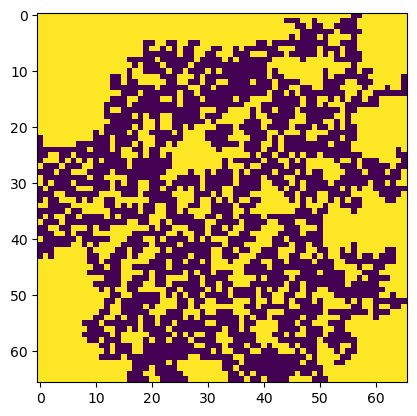

In [28]:
import matplotlib.pyplot as plt

plt.imshow(watershed_dafs[0][0].cpu())

In [51]:
class MassMapsMetrics(nn.Module):
    def __init__(self, void_threshold=0, cluster_threshold=3):
        super().__init__()
        self.void_threshold = void_threshold
        self.cluster_threshold = cluster_threshold
        self.daf_types = ['void', 'cluster']
        self.daf_types2id = {
            'void': 0,
            'cluster': 1
        }
        
    def forward(self, daf_preds, X):
        """
        daf_preds: list of N tensors (M, H, W)
        X: image (N, M, H, W)
        """
        res = []
        for daf_masks, img in zip(daf_preds, X):
            daf_types = []
            # todo: optimize
            for daf_mask in daf_masks:
                masked_img = img * daf_mask.float()
                mask_intensity = (masked_img.squeeze()[(daf_mask > 1e-4)].mean()).item()
                sigma = img.std().item()
                if mask_intensity < self.void_threshold * sigma:
                    daf_type = self.daf_types2id['void']
                elif mask_intensity > self.cluster_threshold * sigma:
                    daf_type = self.daf_types2id['cluster']
                else:
                    daf_type = -1
                daf_types.append(daf_type)
            res.append(daf_types)
        return res

In [52]:
massmaps_metrics = MassMapsMetrics()

In [53]:
results = massmaps_metrics(watershed_dafs, images)

In [56]:
results

[[-1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  0],
 [0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  0,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  1,
  -1,
  0,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  0],
 [0,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  